In [1]:
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from pprint import pprint
from tqdm import tqdm

In [2]:
LABEL_INT_DICT = np.unique(pd.read_csv('ucf11_train_vid.csv')['label'])
pprint(LABEL_INT_DICT)
LABEL_STR_DICT = {k:v for v,k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_STR_DICT)

array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [3]:
import albumentations as A
import cv2
import math
import tensorflow as tf
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, mode='train', shuffle=True):
        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_size = image_size
        
        if self.mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
            ])
            
        self.img_paths = glob(
            f'UCF11_updated_png/{mode}/*.png'
        )
        
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.img_paths[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
    
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for img_path in data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                augmented = self.transform(image=img)
                img = augmented['image']
            
            img = img.astype('float32')
            img = img / 255.
            
            label = img_path.split('\\')[-1].split('_')[0]
            label = LABEL_STR_DICT[label]
            
            batch_x.append(img)
            batch_y.append(label)
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.img_paths)

In [4]:
train_generator = DataGenerator(
    mode='train',
    batch_size=128,
    image_size=256,
    shuffle=True
)
valid_generator = DataGenerator(
    mode='valid',
    batch_size=128,
    image_size=256,
    shuffle=True
)

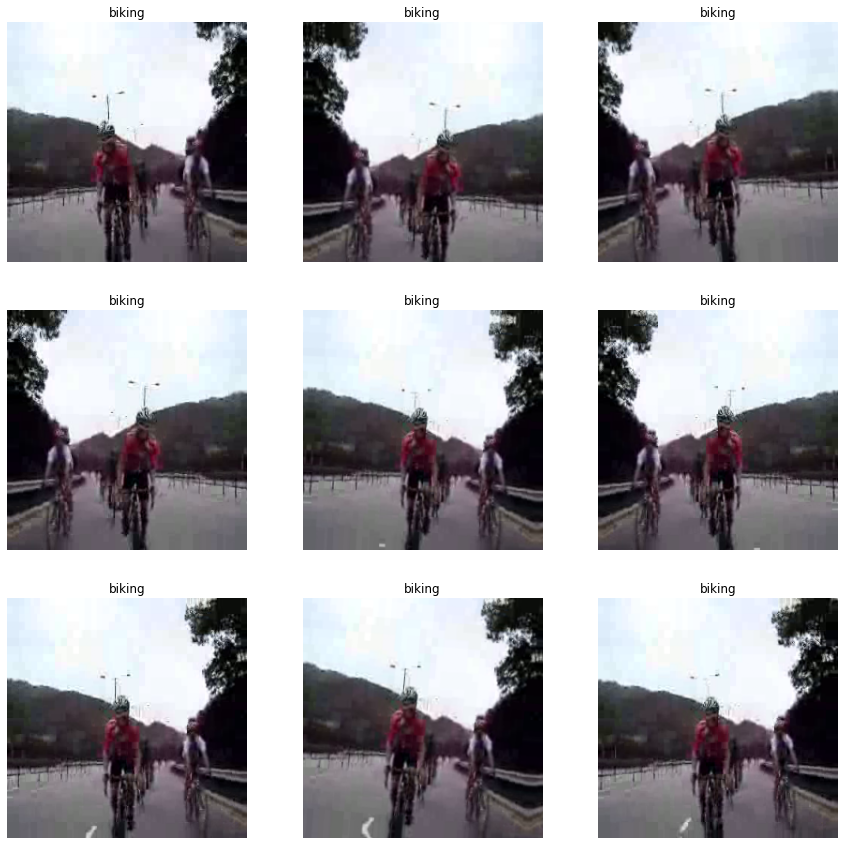

In [5]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(LABEL_INT_DICT[y[i]])
        plt.axis('off')
    break

In [ ]:
# tensorflow hub
# https://tfhub.dev/google//imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
import tensorflow_hub 

model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google//imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2', trainable=True),
    tf.keras.layers.Dense(len(LABEL_INT_DICT), activation='softmax')
])

model.build([None, 256, 256, 3])

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer=adam,
    loss='sparse_categorical_crossentropy',
    metrics='accuracy'
)

model.summary()